In [37]:
import torch
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from gluonts.evaluation.backtest import make_evaluation_predictions
from gluonts.dataset.common import ListDataset
from gluonts.evaluation import MultivariateEvaluator
from pts.model.transformer_tempflow import TransformerTempFlowEstimator
from pts import Trainer
from sklearn.metrics import mean_absolute_error, median_absolute_error, mean_squared_error
from typing import List

sys.path.append("..")
from timefusion.utils import metrics

In [38]:
# Import dataset
train_data = pd.read_csv("../datasets/electricity/train.csv", index_col="date")
val_data = pd.read_csv("../datasets/electricity/val.csv", index_col="date")
test_data = pd.read_csv("../datasets/electricity/test.csv", index_col="date")

#train_data = train_data.iloc[:1000,:10]
#val_data = val_data.iloc[:1000,:10]
#test_data = test_data.iloc[:1000,:10]

# Normalize the signal power of each column
stds = train_data.std()
train_data /= stds
val_data /= stds
test_data /= stds

In [39]:
context_length = 48
prediction_length = 24

# Convert data into a glounts ListDataset
def get_dataset(df: pd.DataFrame, freq: str = "h", indices: List[int] = [-1]) -> ListDataset:
    return ListDataset(
        [
            {
                "start": df.index[0],
                "target": df.values[:i].T,
            }
            for i in indices
        ],
        freq=freq,
        one_dim_target=False
    )

train_dataset = get_dataset(train_data)
val_dataset = get_dataset(val_data)
test_dataset = get_dataset(test_data, indices=list(range(test_data.shape[0], test_data.shape[0] - 14*prediction_length, -prediction_length)))


In [40]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [41]:
estimator = TransformerTempFlowEstimator(
    d_model=16,
    num_heads=4,
    input_size=44,
    target_dim=train_data.shape[1],
    prediction_length=prediction_length,
    context_length=context_length,
    flow_type='MAF',
    dequantize=True,
    freq="h",
    trainer=Trainer(
        device=device,
        epochs=14,
        learning_rate=1e-3,
        num_batches_per_epoch=100,
        batch_size=64,
    ),
)

In [42]:
# Train model
predictor = estimator.train(train_dataset,num_workers=2)

/Users/edvard/Documents/Imperial College/Year 4/Final Year Project/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:324: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  timestamp = pd.Timestamp(timestamp_input, freq=freq)
/Users/edvard/Documents/Imperial College/Year 4/Final Year Project/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:327: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  if isinstance(timestamp.freq, Tick):
/Users/edvard/Documents/Imperial College/Year 4/Final Year Project/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:329: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  timestamp.floor(timestamp.freq), timestamp.freq
/Users/edvard/Documents/Imperial College/Year 4/Final Year Project/Final-Year-Project/timegrad/.venv

  0%|          | 0/99 [00:02<?, ?it/s]

/Users/edvard/Documents/Imperial College/Year 4/Final Year Project/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/Users/edvard/Documents/Imperial College/Year 4/Final Year Project/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/transform/feature.py:352: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._min_time_point, self._max_time_point, freq=start.freq
/Users/edvard/Documents/Imperial College/Year 4/Final Year Project/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/Users/edvard/Documents/Imperial College/Year 4/Final Year Project/Final-Year-Project/tim

RuntimeError: mat1 and mat2 shapes cannot be multiplied (3072x1280 and 44x16)

In [20]:
evaluator = MultivariateEvaluator(quantiles=(np.arange(20)/20.0)[1:],
                                  target_agg_funcs={'sum': np.sum})

In [21]:

forecast_it, ts_it = make_evaluation_predictions(dataset=test_dataset,
                                             predictor=predictor,
                                             num_samples=100)
forecasts = list(forecast_it)
targets = list(ts_it)

agg_metric, _ = evaluator(targets, forecasts, num_series=len(test_dataset))

/Users/edvard/Documents/Imperial College/Year 4/Final Year Project/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:324: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  timestamp = pd.Timestamp(timestamp_input, freq=freq)
/Users/edvard/Documents/Imperial College/Year 4/Final Year Project/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:327: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  if isinstance(timestamp.freq, Tick):
/Users/edvard/Documents/Imperial College/Year 4/Final Year Project/Final-Year-Project/timegrad/.venv/lib/python3.10/site-packages/gluonts/dataset/common.py:329: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  timestamp.floor(timestamp.freq), timestamp.freq
/Users/edvard/Documents/Imperial College/Year 4/Final Year Project/Final-Year-Project/timegrad/.venv

In [22]:

print("CRPS: {}".format(agg_metric['mean_wQuantileLoss']))
print("ND: {}".format(agg_metric['ND']))
print("NRMSE: {}".format(agg_metric['NRMSE']))
print("MSE: {}".format(agg_metric['MSE']))

CRPS: 0.23590589924365937
ND: 0.2828768642474405
NRMSE: 0.3704165257077077
MSE: 0.6444251158335689


In [23]:
len(forecasts)

14

In [24]:
forecasts[0].samples.shape

(100, 24, 10)

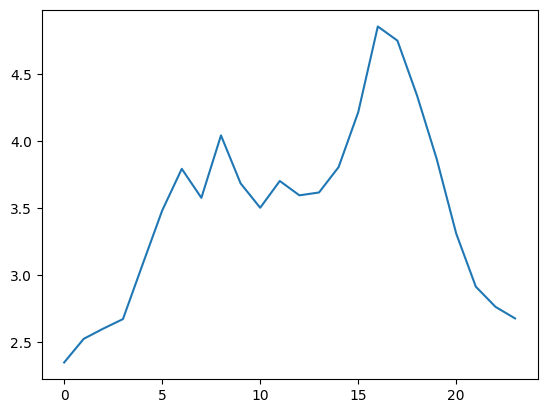

In [36]:
plt.plot(np.mean(forecasts[0].samples,axis=0)[:,7])

In [31]:
np.mean(forecasts[0].samples,axis=0)[:,1]

(24, 10)

In [ ]:
forecasts[]